In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from tabulate import tabulate

import segmentation_models as sm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold

SAVE_PLOTS = True
PATH = "./deep_learning"
if SAVE_PLOTS and not os.path.exists(PATH):
    os.mkdir(PATH)

Segmentation Models: using `keras` framework.


In [53]:
# Read images and masks

images = []
masks = []

IMG_NO = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
size = (512, 512)

for i in IMG_NO:
    for letter in ['L', 'R']:
        img = cv2.imread('./CHASEDB1/Image_' + str(i).zfill(2) + f'{letter}.jpg')
        mask = cv2.imread('./CHASEDB1/Image_' + str(i).zfill(2) + f'{letter}_1stHO.png', cv2.IMREAD_GRAYSCALE)
        # img = cv2.imread('./all/images/' + str(i).zfill(2) + f'_{letter}.jpg')
        # mask = cv2.imread('./all/manual1/' + str(i).zfill(2) + f'_{letter}.tif', cv2.IMREAD_GRAYSCALE)

        if mask is None:
            print('Cannot read mask')
            exit(0)

        if img is None:
            print('Cannot read image')
            exit(0)

        img = img.astype(np.float32)  # konwertujemy typ danych na float32
        img = img / 255.0
        img = cv2.resize(img, size)
        images.append(img)

        mask = mask.astype(np.float32)  # konwertujemy typ danych na float32
        mask = mask / 255.0
        mask = cv2.resize(mask, size)
        masks.append(mask)

In [54]:

# Podział na zbiory treningowe i walidacyjne
X_train, X_valid, Y_train, Y_valid = train_test_split(images, masks, train_size=0.9, random_state=42)

In [55]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_valid = np.array(X_valid)
Y_valid = np.array(Y_valid)

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_valid shape:", X_valid.shape)
print("Y_valid shape:", Y_valid.shape)

X_train shape: (19, 512, 512, 3)
Y_train shape: (19, 512, 512)
X_valid shape: (3, 512, 512, 3)
Y_valid shape: (3, 512, 512)


In [56]:
model = sm.Unet(
    'vgg16',
    input_shape=(512, 512, 3),
    classes=1,
    activation='sigmoid'
)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score]
)

In [58]:
batch_size = 10
epochs = 2

kfold = KFold(n_splits=3, shuffle=True)

for train_index, val_index in kfold.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    Y_train_fold, Y_val_fold = Y_train[train_index], Y_train[val_index]
    
    
    history = model.fit(
        X_train_fold, Y_train_fold,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val_fold, Y_val_fold),
        callbacks=[
            ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_iou_score', mode='max'),
            ReduceLROnPlateau(monitor='val_iou_score', factor=0.1, patience=5, verbose=1, mode='max', min_lr=1e-6)
        ]
    )

Epoch 1/2
2/2 [==============================] - 31s 10s/step - loss: 1.8734 - iou_score: 0.0850 - val_loss: 2.4860 - val_iou_score: 0.0756 - lr: 1.0000e-04
Epoch 2/2
2/2 [==============================] - 32s 10s/step - loss: 1.8453 - iou_score: 0.0785 - val_loss: 2.4756 - val_iou_score: 0.0765 - lr: 1.0000e-04
Epoch 1/2
2/2 [==============================] - 34s 12s/step - loss: 1.8129 - iou_score: 0.0949 - val_loss: 2.5636 - val_iou_score: 0.0769 - lr: 1.0000e-04
Epoch 2/2
2/2 [==============================] - 34s 12s/step - loss: 1.7840 - iou_score: 0.0904 - val_loss: 2.5575 - val_iou_score: 0.0785 - lr: 1.0000e-04
Epoch 1/2
2/2 [==============================] - 34s 12s/step - loss: 1.7621 - iou_score: 0.0975 - val_loss: 2.4576 - val_iou_score: 0.0831 - lr: 1.0000e-04
Epoch 2/2
2/2 [==============================] - 39s 12s/step - loss: 1.7410 - iou_score: 0.0972 - val_loss: 2.4200 - val_iou_score: 0.0837 - lr: 1.0000e-04


In [ ]:
model = load_model('best_model.h5', compile=False)

IMG_NO = [12, 13, 14]
images = []
masks = []

for i in IMG_NO:
    for letter in ['L', 'R']:
        if i == 13 and letter == 'R':
            continue
        img = cv2.imread('./CHASEDB1/Image_' + str(i).zfill(2) + f'{letter}.jpg')
        mask = cv2.imread('./CHASEDB1/Image_' + str(i).zfill(2) + f'{letter}_1stHO.png', cv2.IMREAD_GRAYSCALE)

        if mask is None:
            print('Cannot read mask')
            exit(0)

        if img is None:
            print('Cannot read image')
            exit(0)

        img = img.astype(np.float32)
        img = img / 255.0
        img = cv2.resize(img, size)

        images.append(img)

        mask = mask.astype(np.float32)
        mask = mask / 255.0
        mask = cv2.resize(mask, size)

        masks.append(mask)

1/1 [==============================] - 1s 689ms/step


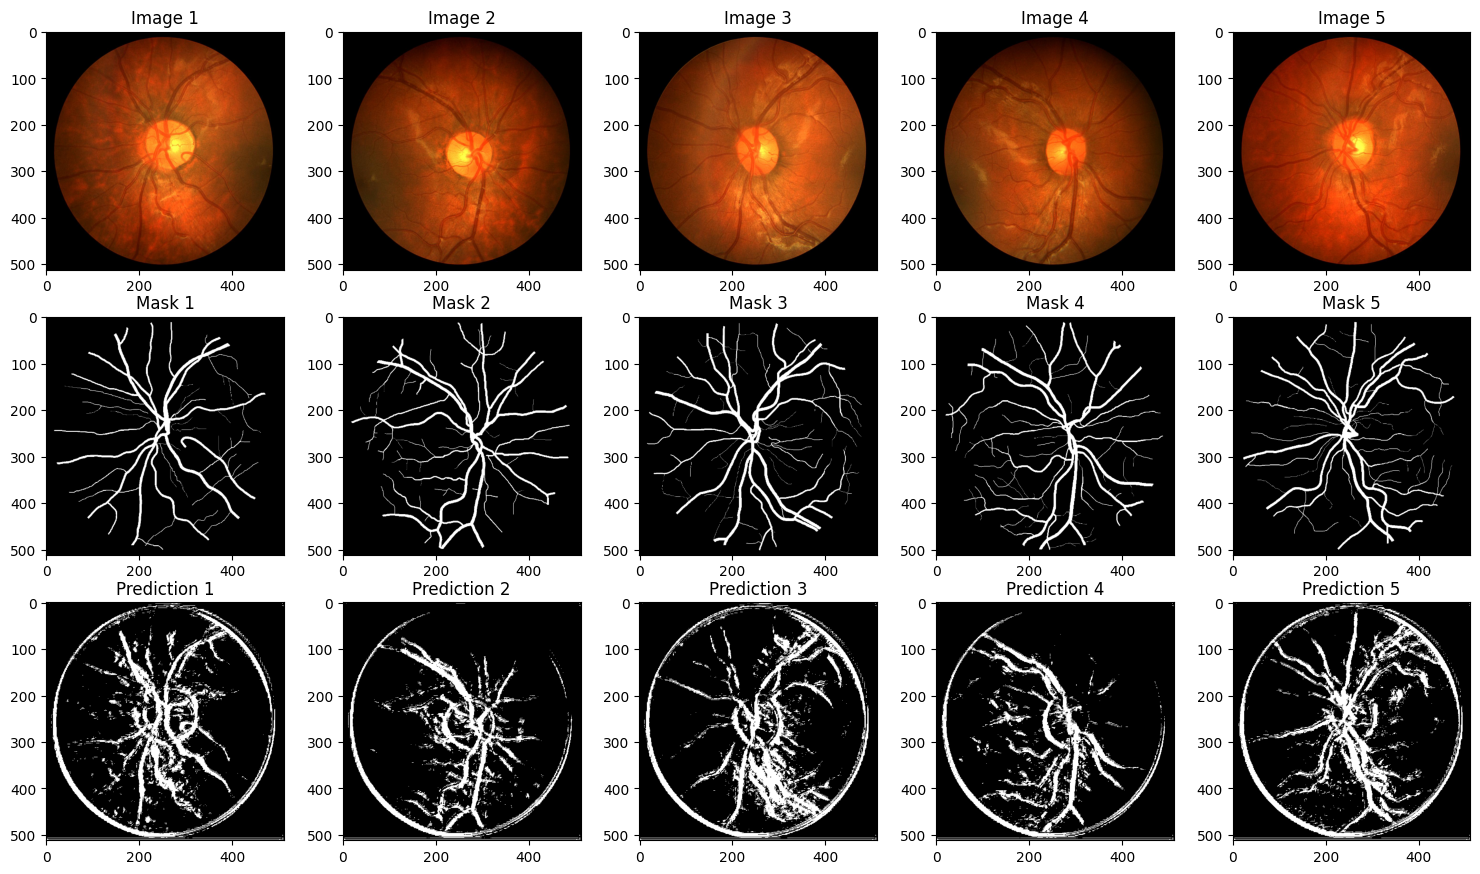

In [61]:
n = 5
fig, ax = plt.subplots(3, n)
fig.set_size_inches(18.5, 10.5)

PREDICTED = []

for k, new_img, mask in zip(range(n), images, masks):

    ax[0, k].imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
    ax[0, k].set_title('Image ' + str(k+1))

    ax[1, k].imshow(mask, cmap='gray')
    ax[1, k].set_title('Mask ' + str(k+1))
    
    new_img = np.expand_dims(new_img, axis=0)
    y_pred = model.predict(new_img)
    y_pred = np.squeeze(y_pred, axis=0)

    threshold = 0.91
    binary_mask = np.where(y_pred > threshold, 1, 0)
    PREDICTED.append(binary_mask)

    ax[2, k].imshow(binary_mask, cmap='gray')
    ax[2, k].set_title('Prediction ' + str(k+1))

if SAVE_PLOTS:
    plt.savefig(f'{PATH}/prediction.png')

| Method   |   Accuracy |   Sensitivity |   Specificity |
|:---------|-----------:|--------------:|--------------:|
| Image 1  |       0.86 |          0.58 |          0.27 |
| Image 2  |       0.88 |          0.5  |          0.33 |
| Image 3  |       0.84 |          0.58 |          0.28 |
| Image 4  |       0.88 |          0.48 |          0.32 |
| Image 5  |       0.85 |          0.63 |          0.29 |
| Mean     |       0.86 |          0.55 |          0.3  |


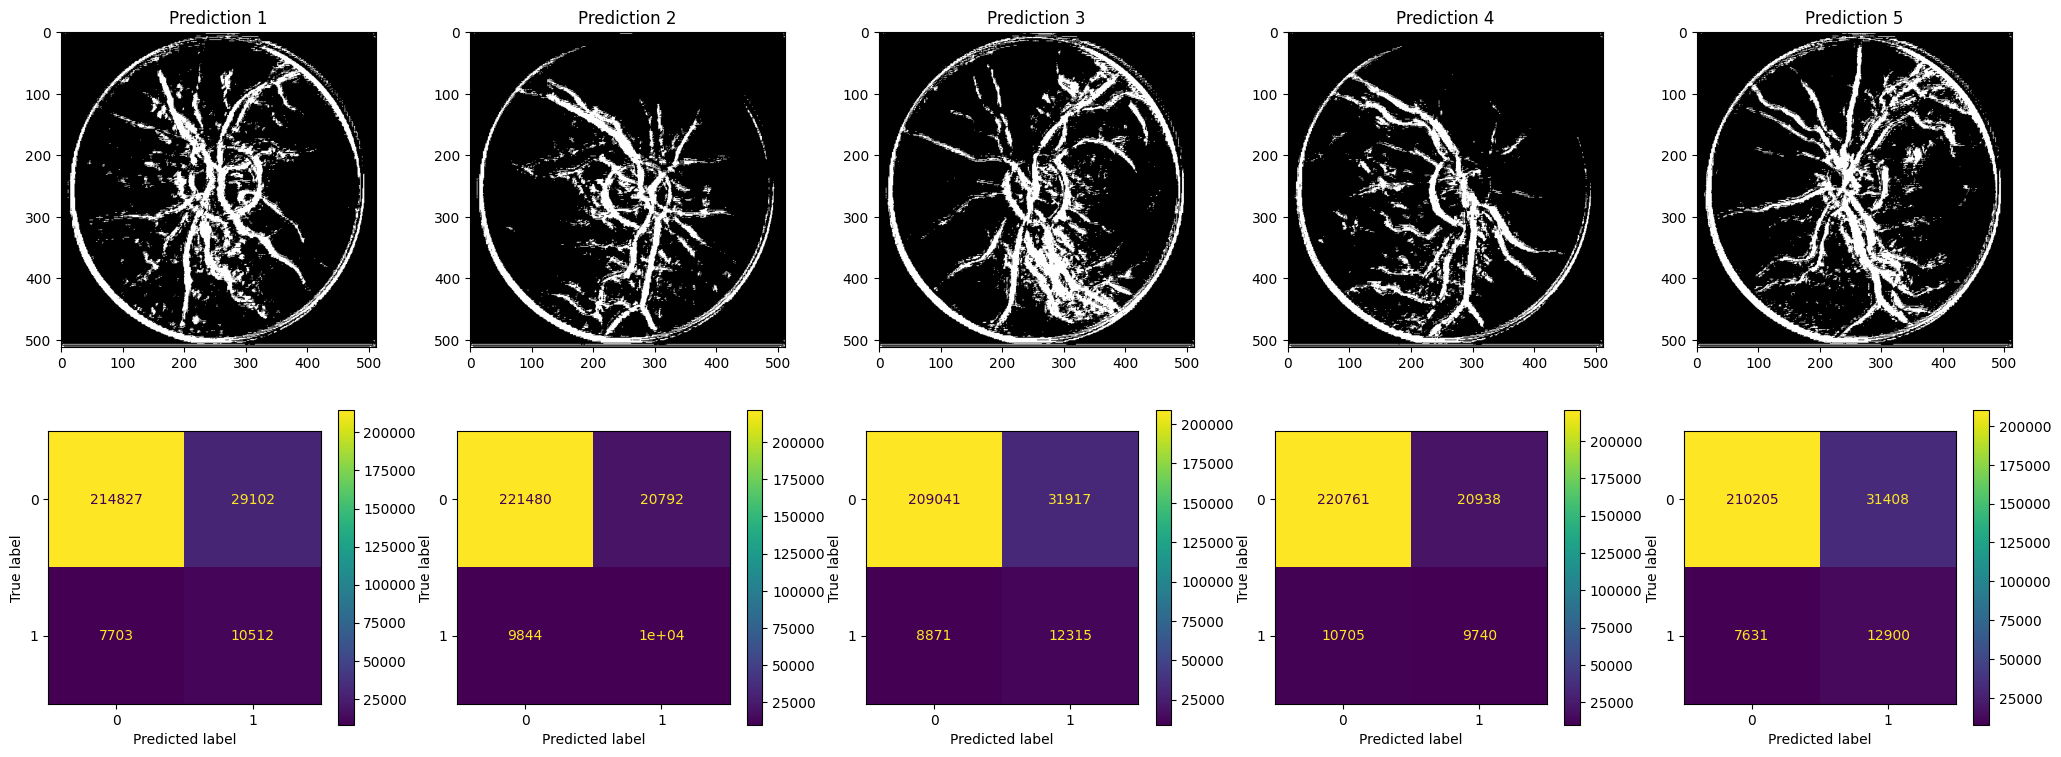

In [63]:
fig, axs = plt.subplots(2, 5) 
fig.set_size_inches(25.5, 9)

headers = ["Method", "Accuracy", "Sensitivity", "Specificity"]
data = []

for i, expert_mask, predicted in zip(range(len(IMG_NO)), masks, PREDICTED):

    y_true = expert_mask.ravel()
    y_true = y_true / y_true.max()
    y_true = np.where(y_true > 0.5, 1, 0)

    
    y_pred = predicted.ravel()
    y_pred = y_pred / y_pred.max()
    y_pred = np.where(y_pred > 0.5, 1, 0)

    cm = confusion_matrix(y_true, y_pred)

    axs[0][i].imshow(predicted, cmap='gray')
    axs[0][i].set_title('Prediction ' + str(i+1))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axs[1][i])

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    data.append([f"Image {i+1}", f"{accuracy:.2f}", f"{recall:.2f}", f"{precision:.2f}"])

data.append(["Mean", f"{np.mean([float(x[1]) for x in data]):.2f}", f"{np.mean([float(x[2]) for x in data]):.2f}", f"{np.mean([float(x[3]) for x in data]):.2f}"])

print(tabulate(data, headers=headers, tablefmt="pipe"))

if SAVE_PLOTS:
    plt.savefig(f'{PATH}/results.png')